In [114]:
set.seed(1)
suppressPackageStartupMessages(require(rstan))
suppressPackageStartupMessages(require(ggplot2))
suppressPackageStartupMessages(require(dplyr))

### Setup

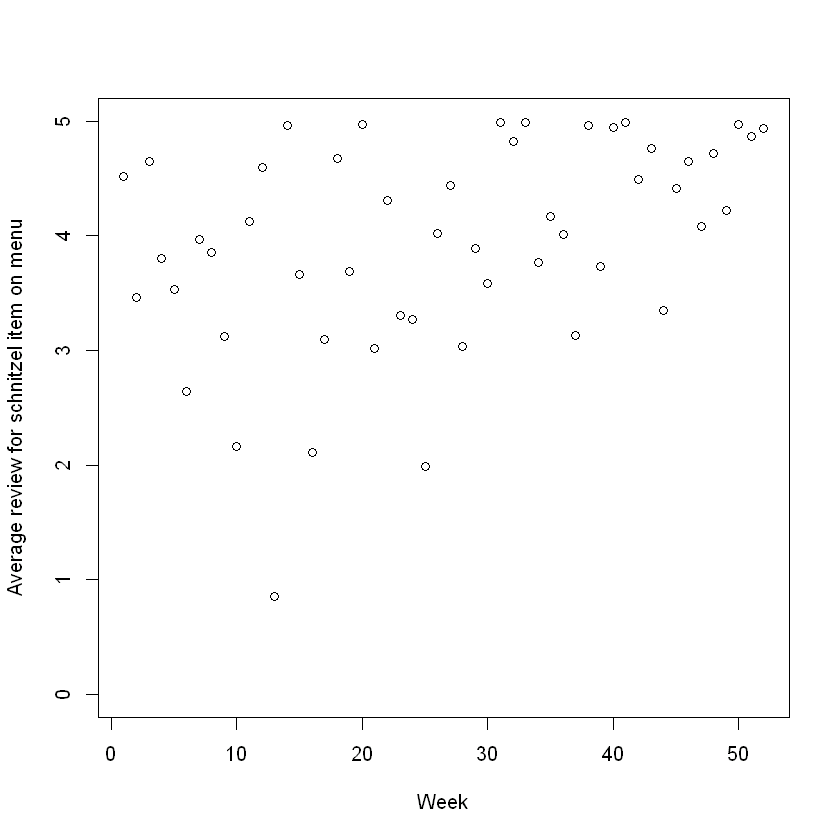

In [46]:
food_data = c(4.52, 3.46, 4.65, 3.8, 3.53, 2.64, 3.97, 3.86, 3.12, 2.16, 4.13, 4.6, 0.86,
    4.96, 3.66, 2.11, 3.1, 4.68, 3.69, 4.97, 3.02, 4.31, 3.31, 3.27, 1.99, 4.02,
    4.44, 3.04, 3.89, 3.59, 4.99, 4.82, 4.99, 3.77, 4.17, 4.01, 3.13, 4.96, 3.73, 4.95,
    4.99, 4.49, 4.76, 3.35, 4.41, 4.65, 4.08, 4.72, 4.22, 4.97, 4.87, 4.94)
plot(1:length(food_data), food_data, xlab = "Week", ylab = "Average review for schnitzel item on menu", 
ylim = c(0,5), xlim = c(1, 52))

In [ ]:
log_joint = function(means, change_point, y) {
  
  # Return log(0.0) if parameters are outside of the support
  if (means[1] < 0.1 | means[2] < 0.1 | means[1] > 0.9 | means[2] > 0.9 | change_point < 1 | change_point > length(y)) 
    return(-Inf)
  
  log_prior = 
    dunif(means[1], 0.1, 0.9, log = TRUE) + 
    dunif(means[2], 0.1, 0.9, log = TRUE)
  
  log_likelihood = 0.0
  for (i in 1:length(y)) {
    mean = if (i < change_point) means[1] else means[2]
    log_likelihood = log_likelihood + dbeta(y[i]/5, mean*5, (1-mean)*5, log = TRUE)
  }
  
  return(log_prior + log_likelihood)
}

### Q1: A custom MCMC sampler

In [118]:
# 3
mcmc = function(means, change_point, y, n_iterations) {
  change_point_trace = rep(-1, n_iterations)
  
  for (i in 1:n_iterations) {
    # K2 for c
    proposed_c = rnorm(1, change_point, sd = 1)
    proposed_c = ifelse(proposed_c >= 0, ceiling(proposed_c), floor(proposed_c)) # proposal
    print(log_joint(means, proposed_c, y))
    print(log_joint(means, change_point, y))
    ratio = exp(log_joint(means, proposed_c, y) - log_joint(means, change_point, y)) #M-H ratio
    change_point = ifelse(runif(1) < min(ratio,1), proposed_c, change_point) # acceptance
    change_point_trace[i] = change_point
    # K1 for mu
    proposed_mu = rnorm(2, means, 1)
    ratio = exp(log_joint(proposed_mu, change_point, y) - log_joint(means, change_point, y))
    means = ifelse(runif(1) < min(ratio,1), proposed_mu, means)
  }
  
  # Return:
  # - the trace of the change points (for question 1) 
  # - the means at the last iteration (for question 2)
  return(
    list(
      change_point_trace = change_point_trace, 
      last_iteration_means = means 
    )
  )
}

### Q2: MCMC correctness testing

In [90]:
# 1
forward = function(synthetic_data_size) {

  mu1 = runif(1, 0.1, 0.9)
  mu2 = runif(1, 0.1, 0.9)
  means = c(mu1, mu2)
  change_point = ceiling(runif(1, 0, synthetic_data_size))
  data = numeric(synthetic_data_size)
  for (i in 1:synthetic_data_size) {
    index = ifelse(i >= change_point, 1, 0) + 1
    data[i] = rbeta(1, means[index]*5, (1-means[index])*5)
  } 
  return(list(
    means = means,
    change_point = change_point,
    data = data
  ))
}

In [91]:
forward_posterior = function(synthetic_data_size, n_mcmc_iters) {
  initial = forward(synthetic_data_size)
  
  if (n_mcmc_iters > 0) {
    samples = mcmc(initial$means, initial$change_point, initial$data, n_mcmc_iters)
    return(samples$last_iteration_means[1])
  } else {
    return(initial$means[1])
  }
}

In [115]:
initial = forward(5)

In [117]:
initial$means
initial$change_point
initial$data

[1] 0.3124069 0.3976991

[1] 3

[1] 0.70432815 0.42389287 0.09985098 0.19390843 0.32636287

In [119]:
# 2
# Note: we use synthetic datasets with only 5 observations to speed things up
forward_only = replicate(1000, forward_posterior(5, 0))
with_mcmc = replicate(1000, forward_posterior(5, 200))

# TODO: perform 2-samples t-test or Kolmogorov-Smirnov test
#       to see if forward_only and with_mcmc follow the same distribution. 

[1] 5.604923
[1] 5.604923


ERROR: Error in if (means[1] < 0.1 | means[2] < 0.1 | means[1] > 0.9 | means[2] > : missing value where TRUE/FALSE needed


### Q3: Using your sampler for data analysis